<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371D Homework 8

### Problem 0 (3 points)

## Part 1: Splitting Rules

In [1]:
def list_class_one_labels(n):
    bits_lists = [[(number >> i) & 1 for i in range(n)] for number in range(1, 2 ** (n-1))]
    return [{index for index, b in enumerate(bits_list) if b} for bits_list in bits_lists]

print(', '.join([str(y1) for y1 in list_class_one_labels(4)]))


{0}, {1}, {0, 1}, {2}, {0, 2}, {1, 2}, {0, 1, 2}


In [3]:
import decision_tree as dtr
import geometry as geo
import numpy as np


def one_rule(samples, n_labels):
    y_samples = dtr.values(samples)
    current_impurity = dtr.impurity(y_samples, n_labels)
    delta_opt, left_opt, right_opt, j_opt, t_opt = -1., None, None, None, None
    d = len(dtr.data_point(samples[0]))
    for j in range(d):
        xjs = np.array([x[j] for x in dtr.data_points(samples)])
        u = np.unique(xjs)
        thresholds = (u[:-1] + u[1:]) / 2.
        for t in thresholds:
            left, right = dtr.pick(samples, xjs <= t), dtr.pick(samples, xjs > t)
            delta = dtr.impurity_change(current_impurity, dtr.values(left), dtr.values(right),
                                        y_samples, n_labels)
            if delta > delta_opt:
                delta_opt, left_opt, right_opt, j_opt, t_opt = delta, left, right, j, t
    return left_opt, right_opt, dtr.hyperplane(j_opt, t_opt)

In [4]:
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

def show_data(samples, n_labels, colors=('r', 'g', 'b', 'c')):
    if samples is not None:
        assert n_labels <= len(colors), 'Not enough colors'
        geo.plot_polygon(geo.data_space(), boundary_color='k')
        for label in range(n_labels):
            color = colors[label]
            xs = dtr.data_points(samples)
            xs = xs[dtr.values(samples) == label]
            if len(xs) > 0:
                plt.plot(xs[:, 0], xs[:, 1], marker='o', color=color, linewidth=0.)
        plt.gca().set_aspect(1)
        plt.axis('off')

### Problem 1.1

In [47]:
from sklearn.linear_model import LogisticRegression

def lr_rule(samples, n_labels):
    y_samples = dtr.values(samples)
    current_impurity = dtr.impurity(y_samples, n_labels)
    delta_opt, left_opt, right_opt, boundary_opt = -1., None, None, None
    
    for labels in list_class_one_labels(n_labels):
        
        y_0 = dtr.pick(samples, np.array([y_samples[j] not in labels for j in range(0,len(y_samples))]))
        y_1 = dtr.pick(samples, np.array([y_samples[i] in labels for i in range(0,len(y_samples))]))
        
        if(len(y_0) != 0 and len(y_1) != 0):
            
            xs = np.concatenate((dtr.data_points(y_1), dtr.data_points(y_0)))
            ys = np.concatenate((np.ones((len(dtr.data_points(y_1)))), np.zeros((len(dtr.data_points(y_0))))))
            
            h = LogisticRegression(random_state=0, C=1.e3).fit(xs, ys)
            
            decisionregion = np.array([np.dot(dtr.data_points(samples)[i], np.transpose(h.coef_)) + h.intercept_ for i in range(0,len(y_samples))]) > 0
            right, left = dtr.pick(samples, decisionregion), dtr.pick(samples, np.invert(decisionregion))
            
            delta = dtr.impurity_change(current_impurity, dtr.values(left), dtr.values(right), y_samples, n_labels)
            
            if delta > delta_opt:
                delta_opt, left_opt, right_opt, boundary_opt = delta, left, right, geo.line(h.coef_[0], h.intercept_[0])
                
    return left_opt, right_opt, boundary_opt

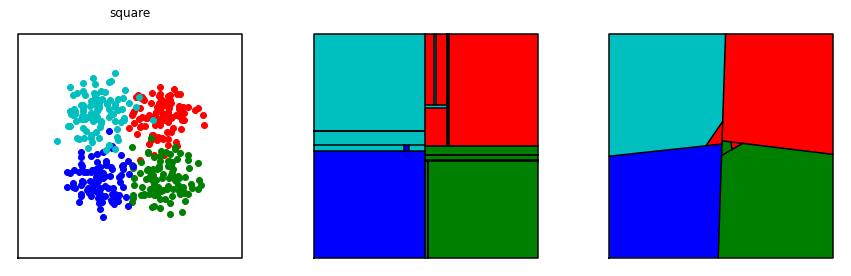

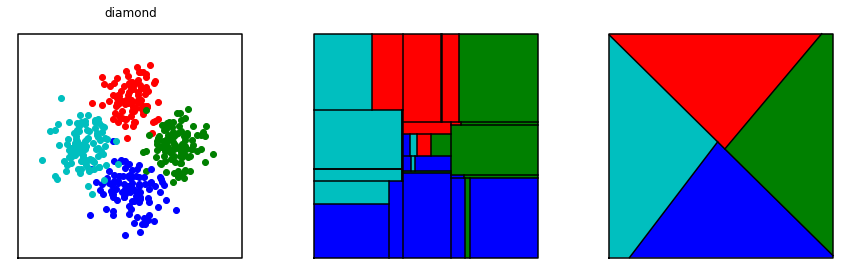

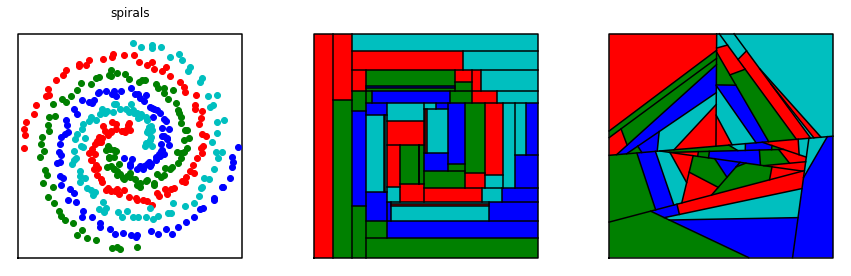

In [85]:
for name in ('square', 'diamond', 'spirals'):
    with open(name+'.pkl', 'rb') as file:
        data = pickle.load(file)
        
    label_colors = data['colors']
    n_classes = len(data['colors'])
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.title(name)
    show_data(data['train'], n_classes, label_colors)
    
    for k, rule in enumerate((one_rule, lr_rule)):
        tree = dtr.train_tree(data['train'], 0, n_classes, rule)
        plt.subplot(1, 3, k+2)
        dtr.plot_decision_regions(tree, 0, geo.data_space(), label_colors)
        plt.gca().set_aspect(1)
        _ = plt.axis('off')


- result on square.pkl: LR rule trained tree has less splits than the one rule trained tree, but they both cover the same decisions boundaries well. Neither is considerably more expressive or generalized because the overall decision regions are so similar, even if one rule ends up having more splits.

- diamond.pkl: Because the LR trained tree is able to split not just on one dimension but on a line defined by both dimensions, mapping this diagonal data works well. The LR tree seems to have less splits than in square.pkl whereas one rule has increased splits when divding up its decision boundaries. LR tree definitely generalizes much better in this case without losing expressiveness.

- spirals.pkl: Although LR rule doesn't seem to have more splits than one rule, there are definitely more than the other two data sets. Because the spiral can't be clearly linearly separated in any certain direction, the LR rule provides a poor approximation. The other training sets could be broken up into subsets that were linearly classifiable, but that's not the case for spirals. 


## Part 2: Logistic-Regression Decision Boundaries for Non-Linearly-Separable Data 

### Problem 2.1 (Exam Style)

- $\xi$ = -b/w

- ln(2)

- It's constant and equal to b because wx will always be equal to zero. There isn't really a decision boundary of x because everything is dependent on b.

- b itself becomes the decision boundary, so when b is negative, h(x) = 0 for all inputs, and when b is positive, h(x) = 1 for all inputs.

### Problem 2.2 (Exam Style)

$$\mathrm{ℓ'(y_{1},a_{1}) = 1/(1 + e^-{a_{1}})} * \left[\begin{array}{c} b' \\ -w' \end{array}\right]
\;\;\;\;\;\;\;\;$$

$$\mathrm{ℓ'(y_{2},a_{2}) = -1/(1 + e^{a_{2}})}* \left[\begin{array}{c} b' \\ 0 \end{array}\right]
\;\;\;\;\;\;\;\;$$

$$\mathrm{ℓ'(y_{3},a_{3}) = 1/(1 + e^-{a_{3}})}* \left[\begin{array}{c} b' \\ w' \end{array}\right]
\;\;\;\;\;\;\;\;$$

$$\mathrm L_{T}(v)= 1/3* \left[\begin{array}{c} {\frac{b'}{1+e^-{a_{1}}} + \frac{-b'}{1+e^{a_{2}}} + \frac{b'}{1+e^-{a_{3}}}} \\ {\frac{-w'}{1+e^-{a_{1}}} + \frac{w'}{1+e^-{a_{3}}}} \end{array}\right]$$


### Problem 2.3 (Exam Style)

0=${\frac{-w'}{1+e^-{a_{1}}} + \frac{w'}{1+e^-{a_{3}}}}$

=${\frac{-w'}{1+e^{w-b}} + \frac{w'}{1+e^{-w-b}}}$

=${\frac{-w'}{1+e^{w-b}} + \frac{w'}{1+e^{-w-b}}}$

=$\mathrm{\frac{-1+e^{2w}}{e^{w}e^{b}}}$

w = 0

0=${\frac{b'}{1+e^-{a_{1}}} + \frac{-b'}{1+e^{a_{2}}} + \frac{b'}{1+e^-{a_{3}}}}$

=${\frac{b'}{1+e^{-b}} + \frac{-b'}{1+e^{b}} + \frac{b'}{1+e^{-b}}}$

=${\frac{2b'}{1+e^{-b}} + \frac{-b'}{1+e^{b}}}$

numerator=$\mathrm{2b'*(1+e^{b})+-b'*(1+e^{-b})}$

-1=$\mathrm{2e^{b}-e^{-b}}$

b = ln(2)

### Problem 2.4 (Exam Style)

h(x)=0

Because the data isn't linearly separable, the classifier isn't going to be able to split the data. Instead, it will just return the mode of the training data which means this classifier will return 0 for all new x values.

## Part 3: Neural Networks 

### Problem 3.1 (Exam Style)

$$ z_{v} = \left[\begin{array}{c} -1 \\ 5 \\ -3 \end{array}\right]$$

$$z_{s} = \left[\begin{array}{c} 0\\ -1 \\ 5 \\ -3 \\ 0 \end{array}\right]$$

$$V_{v} = \left[\begin{array}{c} 1 & 2 & -1 & 0 & 0 \\ 0 & 1 & 2 & -1 & 0 \\ 0 & 0 & 1 & 2 & -1  \end{array}\right] $$

$$V_{s} = \left[\begin{array}{c} 0 & 0 & 0 & 0 & 0 \\ 1 & 2 & -1 & 0 & 0 \\ 0 & 1 & 2 & -1 & 0 \\ 0 & 0 & 1 & 2 & -1 \\ 0 & 0 & 0 & 0 & 0 \end{array}\right] $$


### Problem 3.2 (Exam Style)

$$ Z_{v} = \left[\begin{array}{c} -4 \\ -3 \\ 1 \\ 2 \end{array}\right]$$

$$ Z_{s} = \left[\begin{array}{c} -4 & -3 & 1 & 2 & 0 \\ 0 & 0 & 0 & 0 & 0 \end{array}\right]$$

$$ Z_{w} = \left[\begin{array}{c} -4 \\ 1 \\ 4 \end{array}\right]$$

### Problem 3.3 (Exam Style)

$$\mathrm{q=x_{1}+...+x_{d}}$$

$$\mathrm{Diagonal\; entry\; on\; J_{σ} = {\frac{e^{x_1}}{q}-\frac{e^{2x_1}}{q^{2}}}}$$

$$\mathrm{Off\; Diagonal\; entry\; on\; J_{σ} = \frac{-e^{x_1}*e^{x_n}}{q^{2}}}$$
 
 
$\mathrm{diag(s)=}\begin{bmatrix}
     \frac{e^{x_1}}{q} & \; & 0  \\
      \; & \ddots & \; \\
     0 & \; & \frac{e^{x_n}}{q} \\
  \end{bmatrix}$
  
$\mathrm{ss^{T}=}\begin{bmatrix}
     \frac{e^{2x_1}}{q^{2}} & \dots & \frac{e^{x_1}*e^{x_n}}{q^{2}}  \\
      \vdots&\ddots&\vdots \\
     \frac{e^{x_n}*e^{x_1}}{q^{2}} & \dots & \frac{e^{2x_n}}{q^{2}} \\
  \end{bmatrix}$
  
$\mathrm{J_{σ}=}\begin{bmatrix}
     \frac{e^{x_1}}{q} & \; & 0  \\
      \; & \ddots & \; \\
     0 & \; & \frac{e^{x_n}}{q} \\
  \end{bmatrix}$ -
$\begin{bmatrix}
     \frac{e^{2x_1}}{q^{2}} & \dots & \frac{e^{x_1}*e^{x_n}}{q^{2}}  \\
      \vdots&\ddots&\vdots \\
     \frac{e^{x_n}*e^{x_1}}{q^{2}} & \dots & \frac{e^{2x_n}}{q^{2}} \\
  \end{bmatrix}$
  
=$\begin{bmatrix}
     \frac{e^{x_1}}{q}-\frac{e^{x_1}}{q^{2}} & \: & \frac{-e^{x_1}*e^{x_n}}{q^{2}}  \\
      \vdots&\ddots&\vdots \\
     \frac{-e^{x_n}*e^{x_1}}{q^{2}} & \: & \frac{e^{2x_n}}{q}-\frac{e^{2x_n}}{q^{2}} \\
  \end{bmatrix}$

### Problem 3.4 (Exam Style)



$\sigma(\mathbf{x}+c)$ $= \begin{bmatrix}
     \frac{e^{x_1 + c}}{e^{x_1+c} + ... + e^{x_d+c}}  \\
     \vdots   \\
     \frac{e^{x_d + c}}{e^{x_1+c} + ... + e^{x_d+c}}  \\
  \end{bmatrix}$
  
$= \begin{bmatrix}
     \frac{e^{x_1} e^c}{e^{x_1}e^c + ... + e^{x_d}e^c}  \\
     \vdots   \\
     \frac{e^{x_d} e^c}{e^{x_1}e^c + ... + e^{x_d}e^c}  \\
  \end{bmatrix}$
  
$= \begin{bmatrix}
     \frac{e^c e^{x_1}}{e^c(e^{x_1} + ... + e^{x_d})}  \\
     \vdots   \\
     \frac{e^c e^{x_d}}{e^c(e^{x_1} + ... + e^{x_d})}  \\
  \end{bmatrix}$
  
$= \begin{bmatrix}
     \frac{e^{x_1}}{e^{x_1} + ... + e^{x_d}}  \\
     \vdots   \\
     \frac{e^{x_d}}{e^{x_1} + ... + e^{x_d}}  \\
  \end{bmatrix}$

$= \sigma(\mathbf{x})$

### Problem 3.5 (Exam Style)

$\mathrm{V=}\begin{bmatrix}
     4 & 5  \\
     -6 & 1 \\
  \end{bmatrix}$
 $\mathrm{b=}\begin{bmatrix}
     3  \\
     1 \\
  \end{bmatrix}$